In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Feature Extraction and Raw Data Frame Creation

- In this notebook, we focus on feature selection and feature engineering to create a raw data frame consisting of 6 parts: admission specific, diagnosis, ICU information, demographics, lab results and prescription.

### Admissions specific 
- feature: length of stay: 'length_of_stay' 

In [2]:
patients = pd.read_csv('PATIENTS.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
patients = patients[['SUBJECT_ID','DOD','EXPIRE_FLAG']]

In [3]:
patients.shape

(46520, 3)

In [4]:
admissions = pd.read_csv('ADMISSIONS.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
admissions = admissions[['SUBJECT_ID', 'ADMITTIME', 'DISCHTIME']]
admissions['length_of_stay'] = ( pd.to_datetime(admissions['DISCHTIME']) - pd.to_datetime(admissions['ADMITTIME']) ).dt.days


In [5]:
info = pd.merge(patients, admissions, on='SUBJECT_ID', how='outer')
info['mortality'] = ( pd.to_datetime(info['DOD']) - pd.to_datetime(info['ADMITTIME']) ).dt.days
info['1_yr_mortality'] = np.where(info.mortality.isnull(), 0, np.where(info.mortality >365, 0, 1)) 
info = info[['SUBJECT_ID', 'length_of_stay', '1_yr_mortality']]
info = info.groupby("SUBJECT_ID").sum()

In [6]:
info.shape

(46520, 2)

### Diagnosis  
- feature: number of codes 'diag_NUM' 

In [7]:
icd1 = pd.read_csv('DIAGNOSES_ICD.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
icd1 = icd1[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM']]
icd1.columns = ['SUBJECT_ID', 'HADM_ID', 'diag_NUM']

In [8]:
icd2 = icd1.groupby("HADM_ID").max()
icd2.shape

(58976, 2)

In [9]:
icd = icd2.groupby("SUBJECT_ID").sum()
icd.shape

(46520, 1)

### ICU information 
- feature: length of stay in ICU 'LOS'

In [10]:
icu1 = pd.read_csv('ICUSTAYS.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
icu1 = icu1[['SUBJECT_ID',  'LOS']]

In [11]:
icu1.shape

(61532, 2)

In [12]:
icu = icu1.groupby("SUBJECT_ID").sum()
icu.shape

(46476, 1)

### Merge three features from the first three parts into a csv file
- The saved csv file is named as CMX_features.csv and has three feature columns along with 'SUBJECT_ID'.

In [13]:
merge1 = pd.merge(info, icd, on='SUBJECT_ID', how='outer')
merge1.head(2)

,length_of_stay,1_yr_mortality,diag_NUM
SUBJECT_ID,,,
2,3,0,3.0
3,10,1,9.0


In [14]:
merge1.shape

(46520, 3)

In [15]:
merge2 = pd.merge(merge1, icu, on='SUBJECT_ID', how='outer')
merge2.head(2)

,length_of_stay,1_yr_mortality,diag_NUM,LOS
SUBJECT_ID,,,,
2,3,0,3.0,0.0918
3,10,1,9.0,6.0646


In [16]:
df = merge2
df.isnull().sum()
df = df.fillna(0)
df.head()

,length_of_stay,1_yr_mortality,diag_NUM,LOS
SUBJECT_ID,,,,
2,3,0,3.0,0.0918
3,10,1,9.0,6.0646
4,7,0,9.0,1.6785
5,2,0,3.0,0.0844
6,16,0,8.0,3.6729


In [17]:
df.shape

(46520, 4)

In [18]:
new_df = df[['length_of_stay', 'diag_NUM', 'LOS']]

In [19]:
new_df.to_csv('CMX_features.csv')

### Demographics 
- features: 
    - categorical features: 
        - Marital Status, Ethnicity, encoded by one-hot encoding
        - Gender (binary feature) coded into 0 (Male) and 1 (Female), 'Gender'
    - numerical feature: Age,'Age'                       

In [33]:
PATIENTS = pd.read_csv('PATIENTS.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
ADMISSIONS = pd.read_csv('ADMISSIONS.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

df_demographic  = pd.merge(ADMISSIONS[['SUBJECT_ID','HADM_ID','MARITAL_STATUS','ETHNICITY','ADMITTIME']],PATIENTS[['SUBJECT_ID','GENDER','DOB','DOD']], 
                           left_on=['SUBJECT_ID'], right_on=['SUBJECT_ID'], how = 'inner')

#select only the last admission time for each patient 
df_demographic = df_demographic.groupby('SUBJECT_ID').tail(1)


df_demographic['1_yr_mortality'] = np.where((pd.to_datetime(df_demographic['DOD'])- pd.to_datetime(df_demographic['ADMITTIME'])).dt.days.isnull(), 0, 
                                       np.where((pd.to_datetime(df_demographic['DOD'])- pd.to_datetime(df_demographic['ADMITTIME'])).dt.days<=365 , 1, 0))

### Get Age

In [34]:
df_demographic['ADMITTIME'] = pd.to_datetime(df_demographic['ADMITTIME'])
df_demographic['DOB']= pd.to_datetime(df_demographic['DOB'])

df_demographic['Age'] = 0
df_demographic.head()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,ETHNICITY,ADMITTIME,GENDER,DOB,DOD,1_yr_mortality,Age
0,22,165315,MARRIED,WHITE,2196-04-09 12:26:00,F,2131-05-07,NaN,0,0
2,23,124321,MARRIED,WHITE,2157-10-18 19:34:00,M,2082-07-17,NaN,0,0
3,24,161859,SINGLE,WHITE,2139-06-06 16:14:00,M,2100-05-31,NaN,0,0
4,25,129635,MARRIED,WHITE,2160-11-02 02:06:00,M,2101-11-21,NaN,0,0
5,26,197661,SINGLE,UNKNOWN/NOT SPECIFIED,2126-05-06 15:16:00,M,2054-05-04,2128-02-25 00:00:00,0,0


In [35]:
#fill in age values based on the difference of 'ADMITTIME' and 'DOB'
for i in range(0, len(df_demographic)):
    age = df_demographic.iloc[i,4].year-df_demographic.iloc[i,6].year
    df_demographic.iloc[i,9] = age

In [36]:
df_demographic.head()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,ETHNICITY,ADMITTIME,GENDER,DOB,DOD,1_yr_mortality,Age
0,22,165315,MARRIED,WHITE,2196-04-09 12:26:00,F,2131-05-07,NaN,0,65
2,23,124321,MARRIED,WHITE,2157-10-18 19:34:00,M,2082-07-17,NaN,0,75
3,24,161859,SINGLE,WHITE,2139-06-06 16:14:00,M,2100-05-31,NaN,0,39
4,25,129635,MARRIED,WHITE,2160-11-02 02:06:00,M,2101-11-21,NaN,0,59
5,26,197661,SINGLE,UNKNOWN/NOT SPECIFIED,2126-05-06 15:16:00,M,2054-05-04,2128-02-25 00:00:00,0,72


In [55]:
#save to csv file demographic_without_one_hot.csv for EDA
df_demographic = df_demographic[(df_demographic['Age'] <150) & (df_demographic['Age'] >5)]
df_demographic.to_csv(r'demographic_without_one_hot.csv',header = True)

### Get Marital Status, Ethnicity and Gender 

In [38]:
# Get one hot encoding of ETHNICITY
one_hot = pd.get_dummies(df_demographic['ETHNICITY'])
# Drop ETHNICITY as it is now encoded
df_demographic = df_demographic.drop('ETHNICITY',axis = 1)
# Join the encoded df
df_demographic = df_demographic.join(one_hot)

In [39]:
# Get one hot encoding of columns MARITAL_STATUS
one_hot_m = pd.get_dummies(df_demographic['MARITAL_STATUS'])
# Drop MARITAL_STATUS as it is now encoded
df_demographic = df_demographic.drop('MARITAL_STATUS',axis = 1)
# Join the encoded df
df_demographic = df_demographic.join(one_hot_m)

In [40]:
# Get one hot encoding of columns GENDER
one_hot_gender = pd.get_dummies(df_demographic['GENDER'])
# Drop GENDER as it is now encoded
df_demographic = df_demographic.drop('GENDER',axis = 1)
# Join the encoded df
df_demographic = df_demographic.join(one_hot_gender)
df_demographic = df_demographic.drop('M',axis = 1)
df_demographic.rename(columns={'F': 'GENDER'}, inplace=True)

In [41]:
df_demographic.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DOB,DOD,1_yr_mortality,Age,AMERICAN INDIAN/ALASKA NATIVE,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ASIAN,...,WHITE - OTHER EUROPEAN,WHITE - RUSSIAN,DIVORCED,LIFE PARTNER,MARRIED,SEPARATED,SINGLE,UNKNOWN (DEFAULT),WIDOWED,GENDER
0,22,165315,2196-04-09 12:26:00,2131-05-07,NaN,0,65,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,23,124321,2157-10-18 19:34:00,2082-07-17,NaN,0,75,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,24,161859,2139-06-06 16:14:00,2100-05-31,NaN,0,39,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,25,129635,2160-11-02 02:06:00,2101-11-21,NaN,0,59,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,26,197661,2126-05-06 15:16:00,2054-05-04,2128-02-25 00:00:00,0,72,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [42]:
df_demographic.shape

(46520, 56)

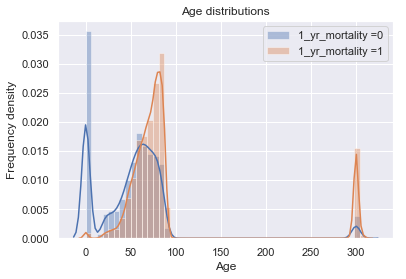

In [43]:
#demographic plot 
sns.set(color_codes=True)
df_0 = df_demographic[df_demographic['1_yr_mortality'] ==0]
df_1 = df_demographic[df_demographic['1_yr_mortality'] ==1]

sns.distplot(df_0['Age'],label ='1_yr_mortality =0')
sns.distplot(df_1['Age'],label ='1_yr_mortality =1')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Frequency density')
plt.title('Age distributions')
plt.savefig('Age_distribution_raw.png')

In [44]:
#age <=150 and avoid newborns 
df_demo_new = df_demographic[(df_demographic['Age'] <150) & (df_demographic['Age'] >5)  ]
print(len(df_demo_new),len(df_demographic))

36655 46520


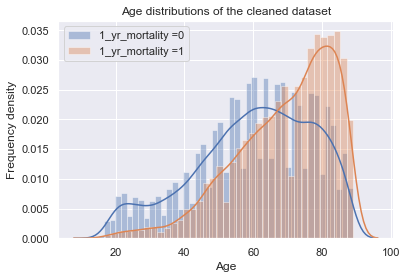

In [45]:
# new demographic plot ruled out newborns and ages over 300
df_0_new = df_demo_new[df_demo_new['1_yr_mortality'] ==0]
df_1_new= df_demo_new[df_demo_new['1_yr_mortality'] ==1]

sns.distplot(df_0_new['Age'],label ='1_yr_mortality =0')
sns.distplot(df_1_new['Age'],label ='1_yr_mortality =1')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Frequency density')
plt.title('Age distributions of the cleaned dataset')
plt.savefig('Age_distribution_cleaned.png')

In [46]:
df_demographic_new = df_demographic.drop(['HADM_ID','ADMITTIME','DOB','DOD','1_yr_mortality'],axis = 1)

In [48]:
df_demographic_new.head()

,SUBJECT_ID,Age,AMERICAN INDIAN/ALASKA NATIVE,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ASIAN,ASIAN - ASIAN INDIAN,ASIAN - CAMBODIAN,ASIAN - CHINESE,ASIAN - FILIPINO,ASIAN - JAPANESE,...,WHITE - OTHER EUROPEAN,WHITE - RUSSIAN,DIVORCED,LIFE PARTNER,MARRIED,SEPARATED,SINGLE,UNKNOWN (DEFAULT),WIDOWED,GENDER
0,22,65,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,23,75,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,24,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,25,59,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,26,72,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Save demographic part into a csv file
- save finalized demographic features to csv file 'demographic_raw.csv' along with 'SUBJECT_ID'

In [47]:
df_demographic_new.to_csv(r'demographic_raw.csv',header = True)

### Lab results (Part I)
- get abnormal percentage for 23 lab tests

In [49]:
labevents = pd.read_csv('LABEVENTS.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
labitems = pd.read_csv('D_LABITEMS.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

In [50]:
unit_unique = labevents['VALUEUOM'].unique()
unit_unique

array(['units', nan, 'mEq/L', 'mmol/L', 'mm Hg', 'mg/dL', 'ug/mL', '%',
       'IU/L', 'g/dL', 'pg', 'fL', 'K/uL', 'm/uL', 'EU/dL', ' ', '#/hpf',
       '#/lpf', 'ng/mL', 'ng/ml', 'sec', 'SECONDS', 'Ratio', '#/uL',
       'mOsm/kg', 'ug/dL', 'uU/ML', 'uG/DL', 'MG/DL', 'L/min', 'uIU/mL',
       'pg/mL', '+/-', 'ng/dL', 'mm/hr', 'umol/L', 'mg/L', 'mIU/mL',
       'GPL', 'MPL', 'MEQ/L', 'MM HG', 'UNITS', 'MOSM/L', 'mg/g', 'IU/mL',
       'Pos/Neg', 'mg/24hr', 'mL', 'Score', 'U/mL', 'mg/24hours', 'ng/dl',
       'mIU/L', 'MOSM/KG', 'ug/ml', 'I.U.', 'NG/DL', '#/CU MM', 'U/g/Hb',
       'ug/L', 'nG/mL', 'U/L', 'mL/min', 'hrs', 'min', 'nG/ML', 'RATIO',
       'U', '/mm3', 'nmol/L'], dtype=object)

In [51]:
# select units with FLAG infomation
unit_unique = np.array(['units', 'mEq/L', 'mmol/L', 'mm Hg', 'mg/dL', 'ug/mL', '%',
       'IU/L', 'g/dL', 'pg', 'fL', 'K/uL', 'm/uL', 'EU/dL', ' ', '#/hpf',
       '#/lpf', 'ng/mL', 'ng/ml', 'sec', 'SECONDS', 'Ratio', '#/uL',
       'mOsm/kg', 'ug/dL', 'uU/ML', 'uG/DL', 'MG/DL', 'uIU/mL',
       'pg/mL', 'ng/dL', 'mm/hr', 'umol/L', 'mg/L', 'mIU/mL',
       'GPL', 'MPL', 'MOSM/L', 'mg/g', 'IU/mL',
       'Score', 'U/mL', 'ng/dl',
       'mIU/L', 'MOSM/KG', 'ug/ml', 'NG/DL', 'U/g/Hb',
       'ug/L', 'nG/mL', 'mL/min', 'min', 'nG/ML', 'RATIO',
       'U', '/mm3', 'nmol/L'], dtype=object)

In [56]:
demo = pd.read_csv('demographic_without_one_hot.csv')

In [57]:
df_label =  demo[['SUBJECT_ID','1_yr_mortality']]
df_label.shape

(36655, 2)

In [58]:
#create abnormal features for every unit
for i in range(len(unit_unique)):
    unit = labevents[(labevents['VALUEUOM'] == unit_unique[i])][['SUBJECT_ID','FLAG']]
    # Get one hot encoding of columns FLAG
    one_hot_unit = pd.get_dummies(unit['FLAG'])
    # Drop column unit as it is now encoded
    unit = unit.drop('FLAG',axis = 1)
    # Join the encoded df
    unit = unit.join(one_hot_unit)
    print(unit_unique[i])
    _, col = unit.shape
    if col ==1:
        print(unit_unique[i],unit_unique[i])
        continue
    unit_flag = unit.groupby(['SUBJECT_ID'])['abnormal'].apply(lambda g: g.sum() / len(g))
    unit_flag = pd.DataFrame(unit_flag)
    df_label = pd.merge(df_label, unit_flag,left_on=['SUBJECT_ID'], right_on=['SUBJECT_ID'], how = 'left')

units
mEq/L
mmol/L
mm Hg
mg/dL
ug/mL
%
IU/L
g/dL
pg
fL
K/uL
m/uL
EU/dL
 
#/hpf
#/lpf
ng/mL
ng/ml
sec
SECONDS
Ratio
#/uL
mOsm/kg
ug/dL
uU/ML
uG/DL
MG/DL
uIU/mL
pg/mL
ng/dL
mm/hr
umol/L
mg/L
mIU/mL
GPL
MPL
MOSM/L
mg/g
IU/mL
Score
U/mL
ng/dl
mIU/L
MOSM/KG
ug/ml
NG/DL
U/g/Hb
ug/L
nG/mL
mL/min
min
nG/ML
RATIO
U
/mm3
nmol/L


In [59]:
#select top 23 features
df_label = df_label.iloc[:,:25]
df_label = df_label.fillna(0)
df_label.columns = df_label.columns[:2].tolist() + unit_unique[:23].tolist()
df_label = df_label.drop('1_yr_mortality', axis = 1)

In [60]:
df_label.head()

,SUBJECT_ID,units,mEq/L,mmol/L,mm Hg,mg/dL,ug/mL,%,IU/L,g/dL,...,EU/dL,,#/hpf,#/lpf,ng/mL,ng/ml,sec,SECONDS,Ratio,#/uL
0,22,0.000000,0.083333,0.000000,0.000,0.052632,0.0,0.125000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0
1,23,0.470588,0.045455,0.555556,0.700,0.352273,1.0,0.476190,0.000000,0.857143,...,0.0,0.5,0.000000,0.0,0.000,0.0,0.250000,0.0,0.0,0.0
2,24,0.000000,0.000000,0.000000,0.500,0.080000,0.0,0.166667,0.400000,0.000000,...,0.0,0.0,0.000000,0.0,0.500,0.0,0.000000,0.0,0.0,0.0
3,25,0.555556,0.140625,0.166667,0.625,0.563636,0.0,0.434783,0.666667,1.000000,...,0.0,0.0,0.000000,0.0,0.625,1.0,0.375000,0.0,0.0,0.0
4,26,0.000000,0.000000,0.000000,0.000,0.557692,0.0,0.428571,0.000000,1.000000,...,0.5,0.0,0.333333,1.0,0.000,0.0,0.454545,0.0,0.0,0.0


In [61]:
df_label.shape

(36655, 24)

### Save lab abnormal percentage features  as csv file
- save finalized abnormal percentage features to csv file 'lab_abnormal.csv' along with 'SUBJECT_ID'

In [62]:
df_label.to_csv(r'lab_abnormal.csv',header = True)

### Lab results (Part II)
- get min, max and mean values for each lab test

In [ ]:
import numpy as np
import pandas as pd
import time as time
admission = pd.read_csv('MIMIC/MIMIC/ADMISSIONS.csv')
bmi =  ['units', 'mEq/L', 'mmol/L', 'mm Hg', 'mg/dL', 'ug/mL', '%',
       'IU/L', 'g/dL', 'pg', 'fL', 'K/uL', 'm/uL', 'EU/dL', '#/hpf',
       '#/lpf', 'ng/mL', 'ng/ml', 'sec', 'SECONDS', 'Ratio', '#/uL',
       'mOsm/kg', 'ug/dL', 'uU/ML', 'uG/DL', 'MG/DL', 'L/min', 'uIU/mL',
       'pg/mL', '+/-', 'ng/dL', 'mm/hr', 'umol/L', 'mg/L', 'mIU/mL',
       'GPL', 'MPL', 'MEQ/L', 'MM HG', 'UNITS', 'MOSM/L', 'mg/g', 'IU/mL',
       'Pos/Neg', 'mg/24hr', 'mL', 'Score', 'U/mL', 'mg/24hours', 'ng/dl',
       'mIU/L', 'MOSM/KG']

new_bmi = []
for e_bmi in bmi:
    new_bmi.append(e_bmi+'_max')
    new_bmi.append(e_bmi+'_min')
    new_bmi.append(e_bmi+'_mean')
new_bmi = np.concatenate((['SUBJECT_ID'], new_bmi))
df_labEvents_features = pd.DataFrame(columns=new_bmi)
df_labEvents_features['SUBJECT_ID'] = admission['SUBJECT_ID'].unique()
LabEvents_df = pd.read_csv('MIMIC/MIMIC/LABEVENTS.csv')
LabEvents_df = LabEvents_df[np.isfinite(LabEvents_df['VALUENUM'])]
st_time = time.time()

id_list = LabEvents_df['SUBJECT_ID'].unique()
print('Start feature extracting')
print('Total Length of id: ', id_list.shape[0])
for step, e_id in enumerate(id_list):
    sj_id_labevents = LabEvents_df.loc[LabEvents_df['SUBJECT_ID'] == e_id] 
    if not sj_id_labevents.empty:
        for e_bmi in bmi:
            sj_bmi_labevents = sj_id_labevents[sj_id_labevents['VALUEUOM'] == e_bmi]['VALUENUM'].values
            if not sj_bmi_labevents.shape[0] == 0:
                max_value = sj_bmi_labevents.max()
                min_value = sj_bmi_labevents.min()
                mean_value = sj_bmi_labevents.mean()
                df_labEvents_features.loc[df_labEvents_features['SUBJECT_ID'] == e_id, [e_bmi + '_max']] = max_value
                df_labEvents_features.loc[df_labEvents_features['SUBJECT_ID'] == e_id, [e_bmi + '_min']] = min_value
                df_labEvents_features.loc[df_labEvents_features['SUBJECT_ID'] == e_id, [e_bmi + '_mean']] = mean_value
    if step % 100 == 0:
        print("Duration: ", time.time()-st_time)
        print("Current step: ", step)
df_labEvents_features.fillna(0)

### Save lab value features  as csv file


In [ ]:
df_labEvents_features.to_csv('LabEvents_features.csv')

### Prescription results
 - > get number of each drug for each patient

In [ ]:
import numpy as np
import pandas as pd
import time as time
admission = pd.read_csv('MIMIC/MIMIC/ADMISSIONS.csv')
df_prescription = pd.read_csv('MIMIC/MIMIC/PRESCRIPTIONS.csv')
drug_focus = df_prescription['DRUG'].value_counts()[:20].index
drug_name = drug_focus

n_drug_name = np.concatenate((['SUBJECT_ID'], drug_name))
df_prescription_features = pd.DataFrame(columns=n_drug_name)
df_prescription_features['SUBJECT_ID'] = admission['SUBJECT_ID'].unique()
st_time = time.time()

id_list = df_prescription['SUBJECT_ID'].unique()
print('Start feature extracting')
print('Total Length of id: ', id_list.shape[0])
for step, e_id in enumerate(id_list):
    sj_id_pres = df_prescription.loc[df_prescription['SUBJECT_ID'] == e_id] 
    if not sj_id_pres.empty:
        for e_drug in drug_name:
            df_prescription_features.loc[df_prescription_features['SUBJECT_ID'] == e_id, [e_drug]] = sj_id_pres[sj_id_pres['DRUG']==e_drug].shape[0]
    if step % 100 == 0:
        print('Current Step ', step)
        print('Duration ', time.time()-st_time)
        
df_prescription_features.fillna(0)


### Save prescription features  as csv file

In [ ]:
df_prescription_features.to_csv('Prescription_features.csv')